# Experimentación - LSTM 



## 1. Obtención de datos



In [1]:
import torch
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import networkx as nx
sns.set_palette("coolwarm_r")
import matplotlib.pyplot as plt
import numpy as np

from torch_geometric.data import Data, Dataset
from torch_geometric.nn import GCNConv

import os, sys

path = os.getcwd()

sys.path.insert(1, "/".join(path.split("/")[0:-1]))

from utils import powergrid

In [2]:
#folder_path = "/home/TFM/code_dataset2/datos/Natural Oscillation"
folder_path = "/Users/maguado/Documents/UGR/Master/TFM/datos_2/Natural Oscillation"

In [3]:
loader = powergrid.PowerGridDatasetLoader(folder_path, problem="classification_type")
_,_,_ =loader.process()
limit = 300
dataset_full, situations_each = loader.get_dataset()


Processing:  row_307
Node:  0  not included, including...
Node:  1  not included, including...
Node:  2  not included, including...
Node:  3  not included, including...
Node:  4  not included, including...
Node:  5  not included, including...
Node:  6  not included, including...
Node:  7  not included, including...
Node:  8  not included, including...
Node:  9  not included, including...
Node:  10  not included, including...
Node:  11  not included, including...
Node:  12  not included, including...
Node:  13  not included, including...
Node:  14  not included, including...
Node:  15  not included, including...
Node:  16  not included, including...
Node:  17  not included, including...
Node:  18  not included, including...
Node:  19  not included, including...
Node:  20  not included, including...
Node:  21  not included, including...
Node:  22  not included, including...
Processing:  row_135
Processing:  row_75
Processing:  row_338
Processing:  row_81
Processing:  row_132
Processing: 

## Funciones auxiliares - entrenamiento

In [4]:
from utils import pygt_loader

try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable
import os
import torch
import torch.nn.functional as F
from utils.utils_graph import format_plot, plot_training_and_eval_losses, plot_predictions
from utils.general_nn import guardar_resultados

from utils.utils_graph import format_plot
from utils import train_lstm
from utils import trainer
import utils.train_lstm
dtype = torch.float
device = torch.device("cpu")

In [10]:
from utils.trainer import train_test_val_split
dataloader_params = {
            "batch_size": 5,
            "data_split_ratio": [0.7, 0.15, 0.15],
            "seed": 42,
            "keep_same": True,
            "use_batch":False
}


loader_s = train_test_val_split(dataset_full, batch_size=dataloader_params["batch_size"],
                                                   data_split_ratio=dataloader_params["data_split_ratio"],
                                                   random_seed=dataloader_params["seed"],
                                                   keep_same=dataloader_params["keep_same"],
                                                   use_batch=dataloader_params["use_batch"])


==================== DATASET INFO ===================

Train dataset: 390
Validation dataset: 75
Test dataset: 84


In [30]:
import utils.train_lstm
import utils.trainer
from importlib import reload  # Python 3.4+
utils.trainer = reload(utils.trainer)
utils.models = reload(utils.models)
from utils.models import LSTMModel
from utils.trainer import  TrainerLSTMModel


In [32]:
n_div_prob = loader.div
n_nodes =dataset_full.features[0].shape[0]
n_target = dataset_full.targets[0].shape[0]
print(n_target)
n_features = dataset_full[0].x.shape[1]
hidden_size =50
n_layers =2
problem ="Classification"
model_prob = LSTMModel(name="LSTM", node_features=n_features, node_count=n_nodes, n_target=n_target, hidden_size=hidden_size, num_layers=n_layers, is_classification = True)

trainer_lstm = TrainerLSTMModel(model_prob, dataset_full,device, f"./results/{problem}", dataloader_params, batch=True)



5
torch.Size([5])
torch.Size([5])


## Prueba - predicción por tipos - usando batch 

Algunos modelos de los que veremos luego admiten entrenamiento por batch, y otros no, por lo que guardaremos los resultados de LSTM en ambos casos, para poder compararlos.

En GNNs el entrenamiento por batch muchas veces carece de sentido, porque estaríamos modelando todos los grafos del mismo batch como el mismo grafo, perdiendo información que puede ser valiosa.

## Bucle rápido para guardar resultados con batch

In [57]:
import utils.train_lstm
import utils.trainer
from importlib import reload  # Python 3.4+
utils.trainer = reload(utils.trainer)
utils.models = reload(utils.models)
from utils.models import LSTMModel
from utils.trainer import  TrainerLSTMModel


In [58]:
dataloader_params2 = {
    "batch_size": 5,
    "data_split_ratio": [0.7, 0.15, 0.15],
    "seed": 42,
    "keep_same": True,
    "use_batch": False
}
params_model = {
    "hidden_size": 50,
    "n_layers": 2
}
problem ="Classification"

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

n_div_prob = loader.div
n_nodes =dataset_full.features[0].shape[0]
n_target = dataset_full.targets[0].shape[0]
n_features = dataset_full[0].x.shape[1]

n_layers = params_model['n_layers']
hidden_size = params_model['hidden_size']


model_prob = LSTMModel(name="LSTM", node_features=n_features, node_count=n_nodes, n_target=n_target, hidden_size=hidden_size, num_layers=n_layers, is_classification=True)

trainer_lstm = TrainerLSTMModel(model_prob, dataset_full,device, f"./results/{problem}", dataloader_params2, batch=True, is_classification=True)
losses, eval_losses, accs, precisions, recalls = trainer_lstm.train(num_epochs=30, steps=50, num_early_stop=15)
test_acc, test_precision, test_recall, test_f1, test_loss, preds, real = trainer_lstm.test()






==================== DATASET INFO ===================

Train dataset: 390
Validation dataset: 75
Test dataset: 84

==================== TRAIN INFO ===================

tensor(4)


TypeError: Singleton array tensor(4) cannot be considered a valid collection.

## Bucle rápido para guardar resultados sin batch

In [7]:
import utils.train_lstm
import utils.trainer
from importlib import reload  # Python 3.4+
utils.trainer = reload(utils.trainer)
from utils.train_lstm import train_lstm_model, test_lstm, LSTMModel
from utils.trainer import train_test_val_split, TrainerLSTMModel


Problem:  gen_trip
Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  184

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.2186 | Eval Loss: 0.0588 | Eval R2: -17.8092 | 
Epoch 2/30 | Train Loss: 0.0377 | Eval Loss: 0.0222 | Eval R2: -7.5046 | 
Epoch 3/30 | Train Loss: 0.0185 | Eval Loss: 0.0155 | Eval R2: -4.0918 | 
Epoch 4/30 | Train Loss: 0.0146 | Eval Loss: 0.0139 | Eval R2: -3.6272 | 
Epoch 5/30 | Train Loss: 0.0130 | Eval Loss: 0.0133 | Eval R2: -3.5560 | 
Epoch 6/30 | Train Loss: 0.0120 | Eval Loss: 0.0122 | Eval R2: -3.1244 | 
Epoch 7/30 | Train Loss: 0.0115 | Eval Loss: 0.0110 | Eval R2: -2.2639 | 
Epoch 8/30 | Train Loss: 0.0107 | Eval Loss: 0.0105 | Eval R2: -2.0271 | 
Epoch 9/30 | Train Loss: 0.0103 | Eval Loss: 0.0103 | Eval R2: -1.9312 | 
Epoch 10/30 | Train Loss: 0.0100 | Eval 

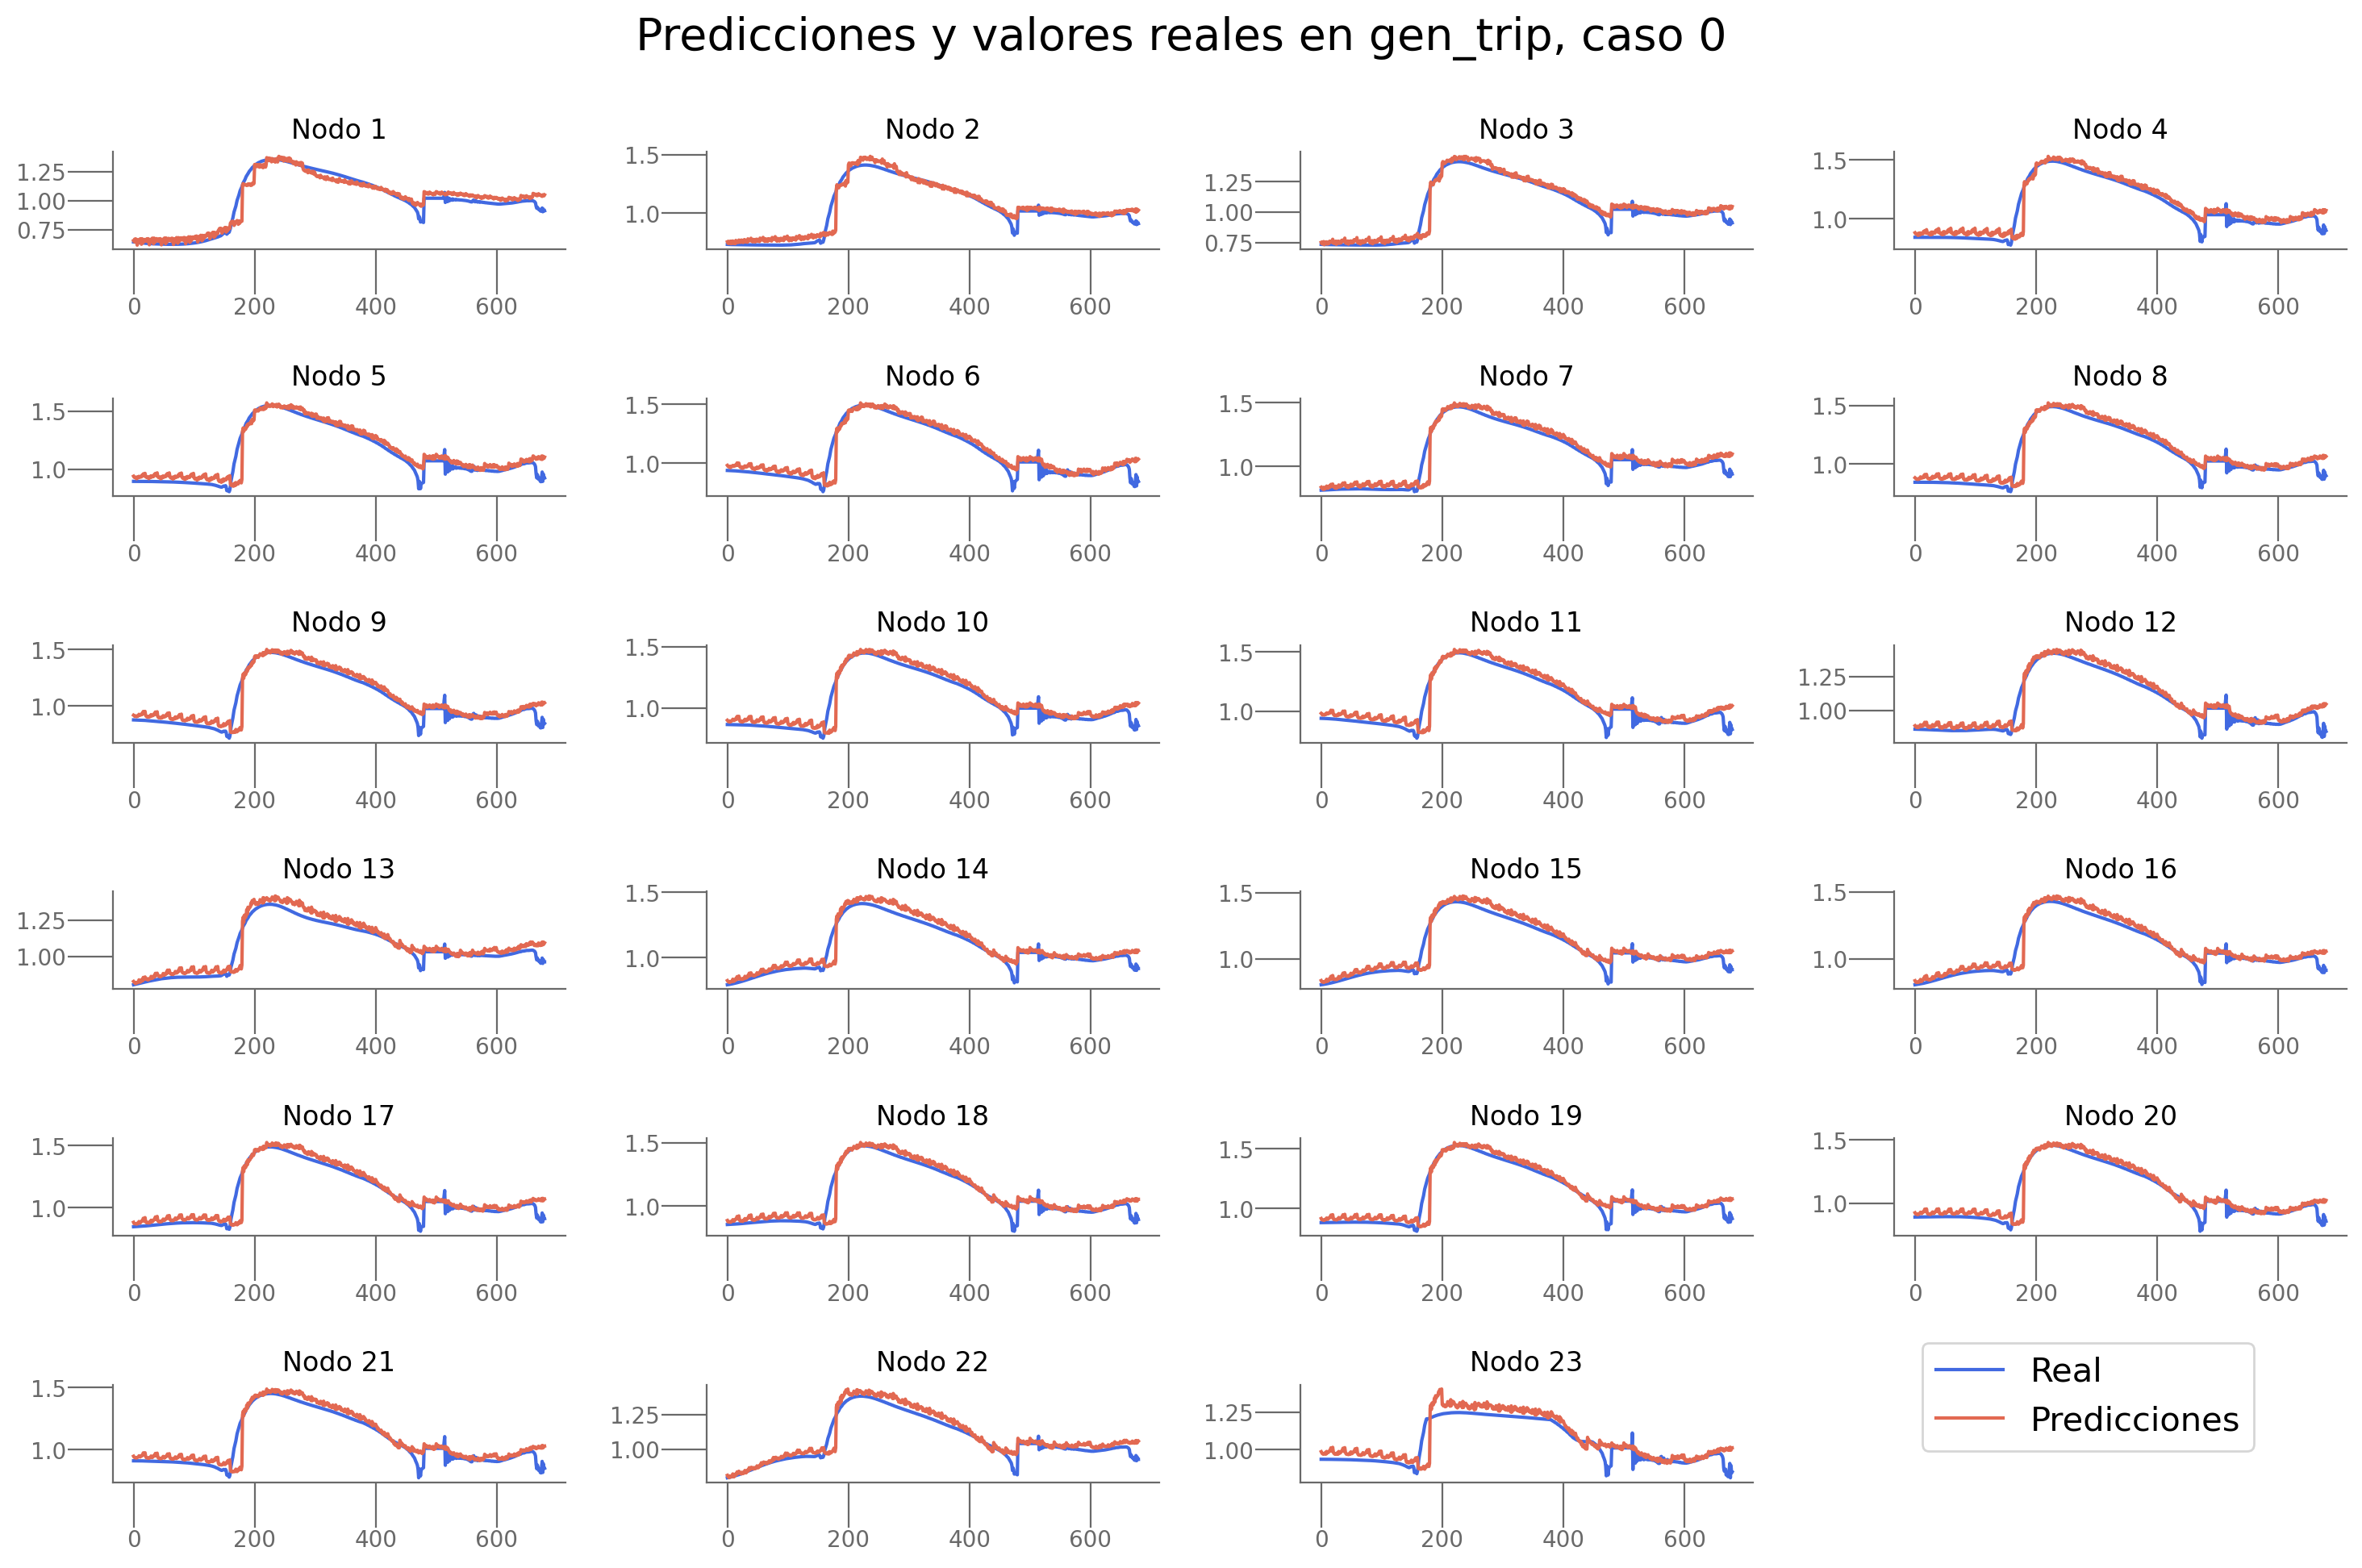


==================== GUARDANDO RESULTADOS ===================

         Modelo                               Params  \
0          LSTM                                  NaN   
1     MPNN_LSTM  {'hidden_size': 16, 'dropout': 0.2}   
2  LSTM_NOBATCH                                 None   

                    Fichero_resultados_experimento  Loss_tst     R2_tst  \
0                                              NaN  0.007638   0.204209   
1  ./results/gen_trip/ajustes/MPNNLSTM_results.csv  0.045889 -18.247558   
2                                             None  0.007437  -1.985579   

                                          Loss_nodes    R2_eval  Loss_eval  \
0  [0.00403222 0.0036478  0.00494586 0.00812658 0...   0.341164   0.009765   
1  [0.04005108401179314, 0.03960233926773071, 0.0... -16.743964   0.052820   
2  [0.005097207, 0.0036072305, 0.004494642, 0.007...  -1.845531   0.009937   

   Loss_final  
0    0.008689  
1    0.059339  
2    0.009110  

==================== RESULTADOS 

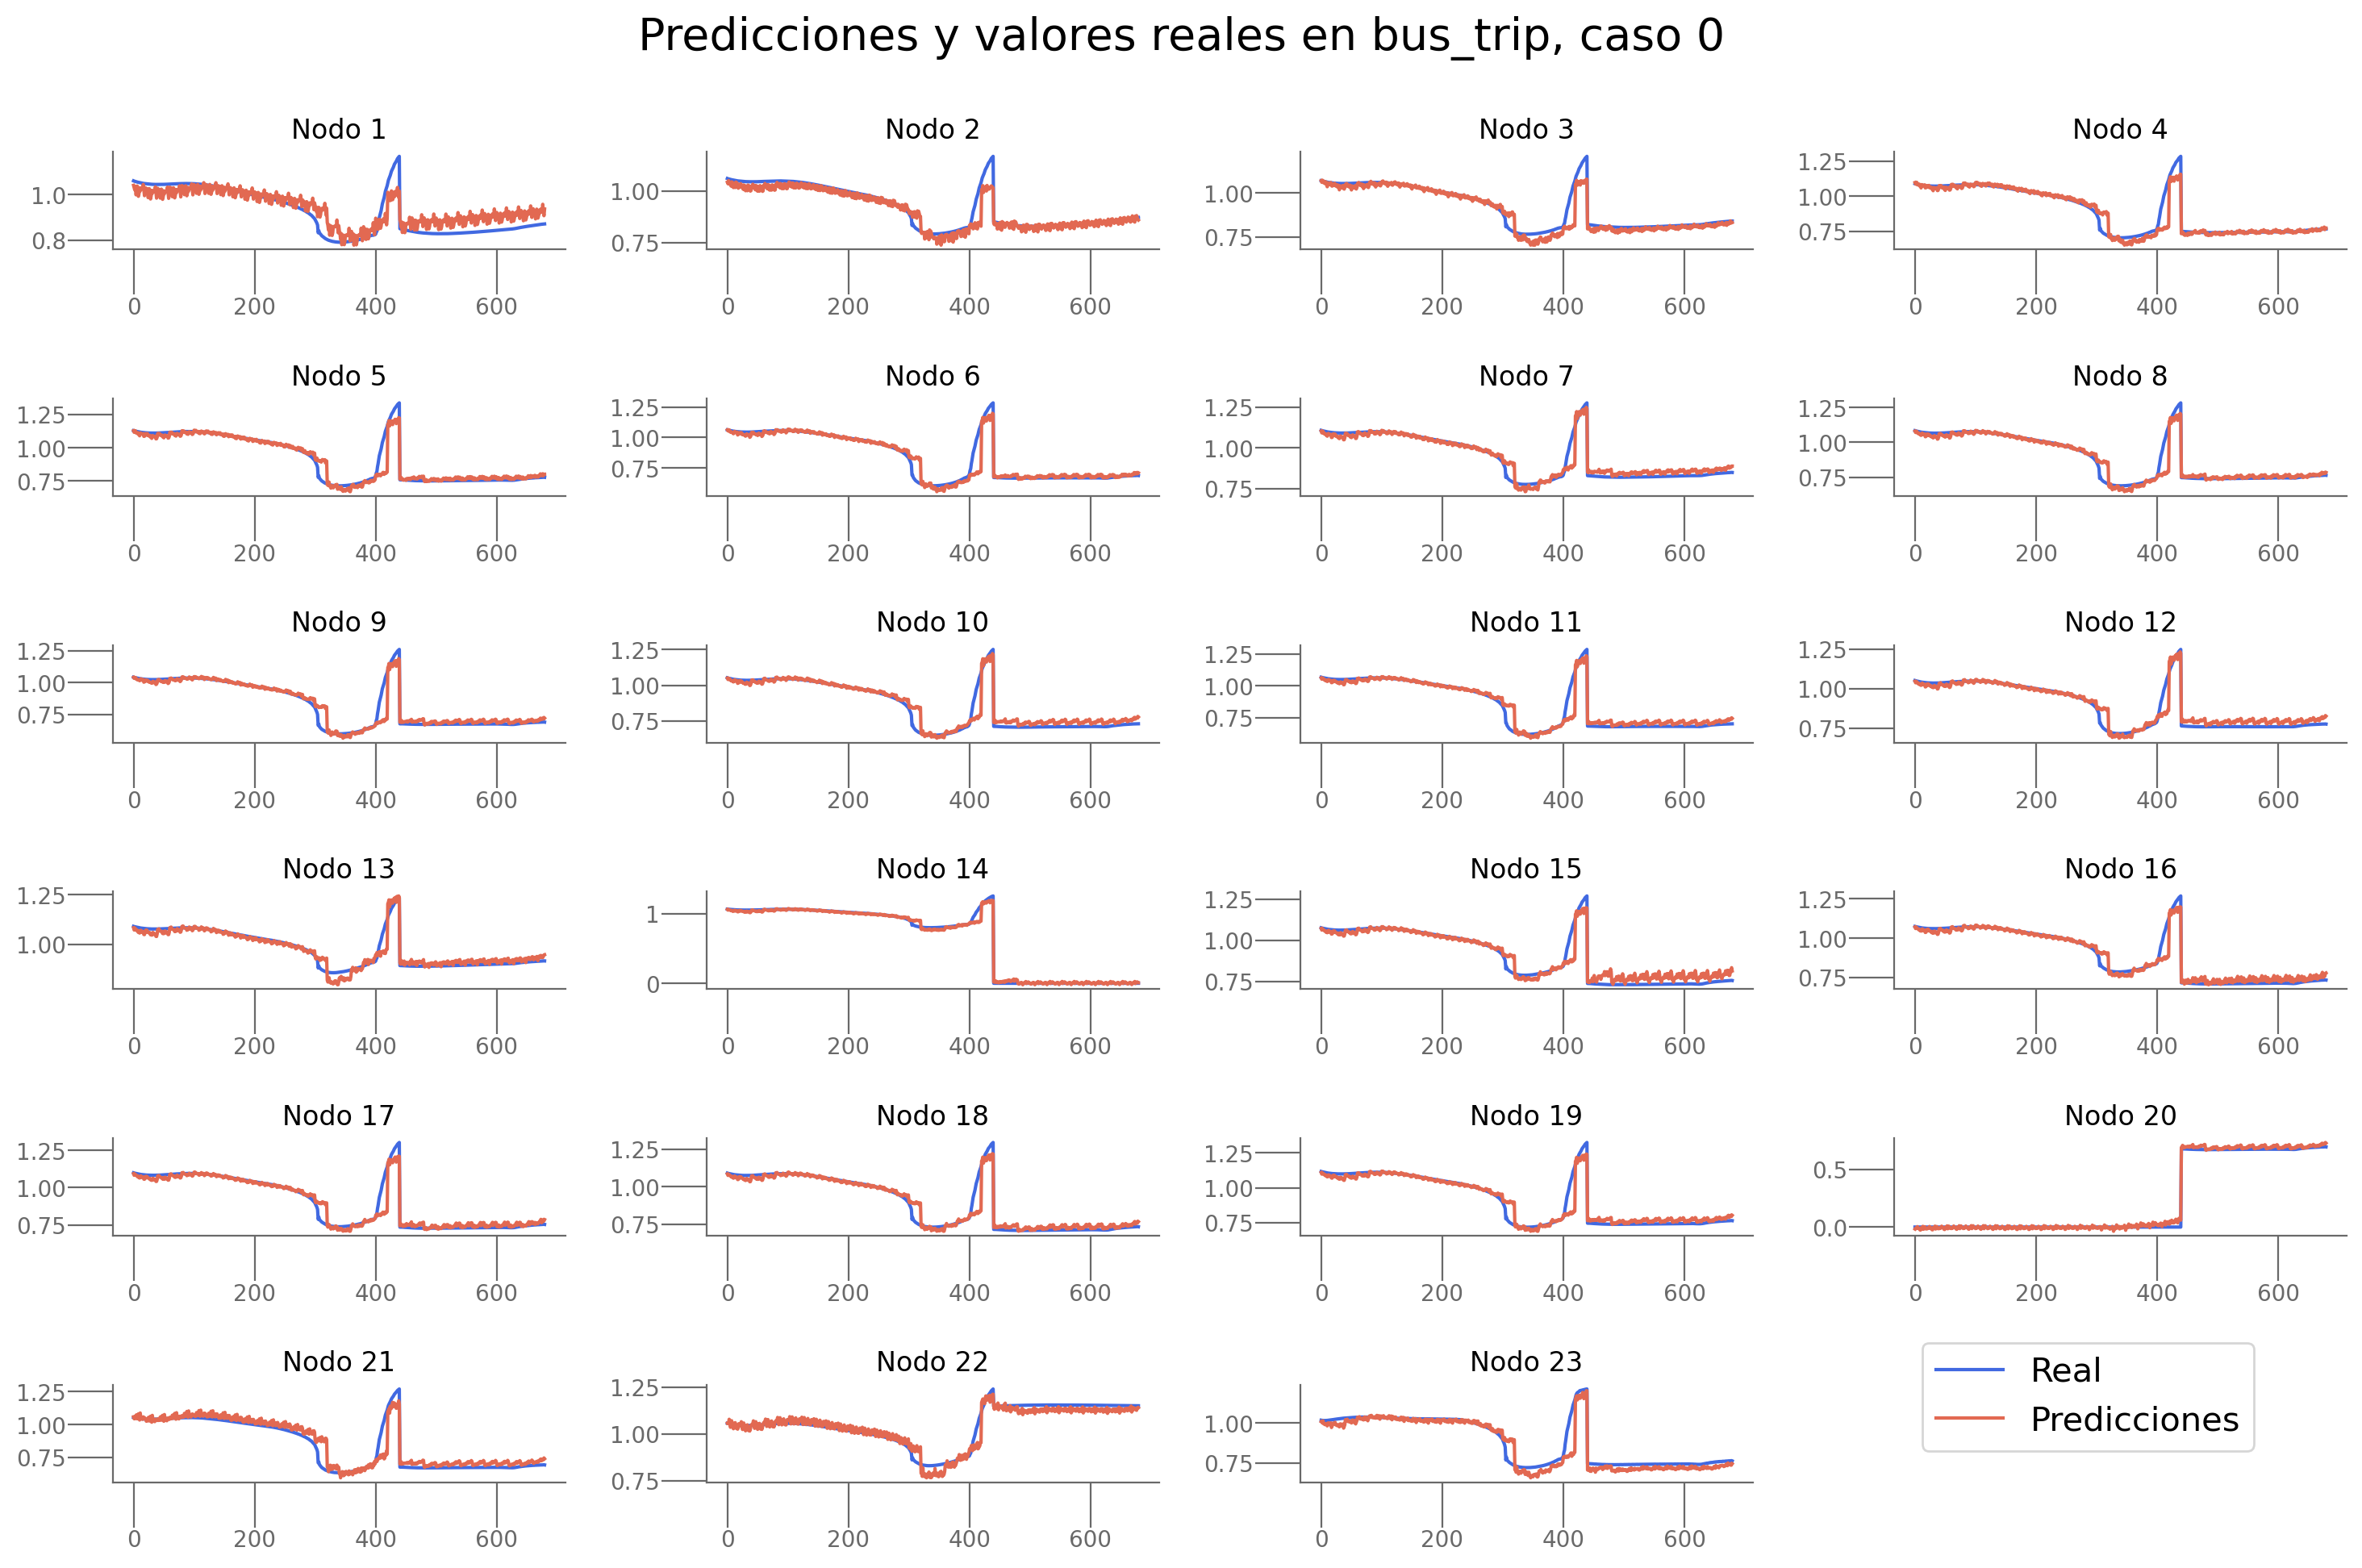


==================== GUARDANDO RESULTADOS ===================

         Modelo Params Fichero_resultados_experimento  Loss_tst    R2_tst  \
0          LSTM    NaN                            NaN  0.005474  0.923150   
1  LSTM_NOBATCH   None                           None  0.005606  0.865487   

                                          Loss_nodes   R2_eval  Loss_eval  \
0  [0.00273813 0.00319852 0.00392416 0.00609108 0...  0.912320   0.005448   
1  [0.0064705517, 0.0064651025, 0.0048990864, 0.0...  0.871289   0.005549   

   Loss_final  
0    0.005502  
1    0.005489  

==================== RESULTADOS GUARDADOS ===================

Problem:  bus_fault
Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  86

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.2531 | Eval Loss: 0.1204 | Eval R2: -17.

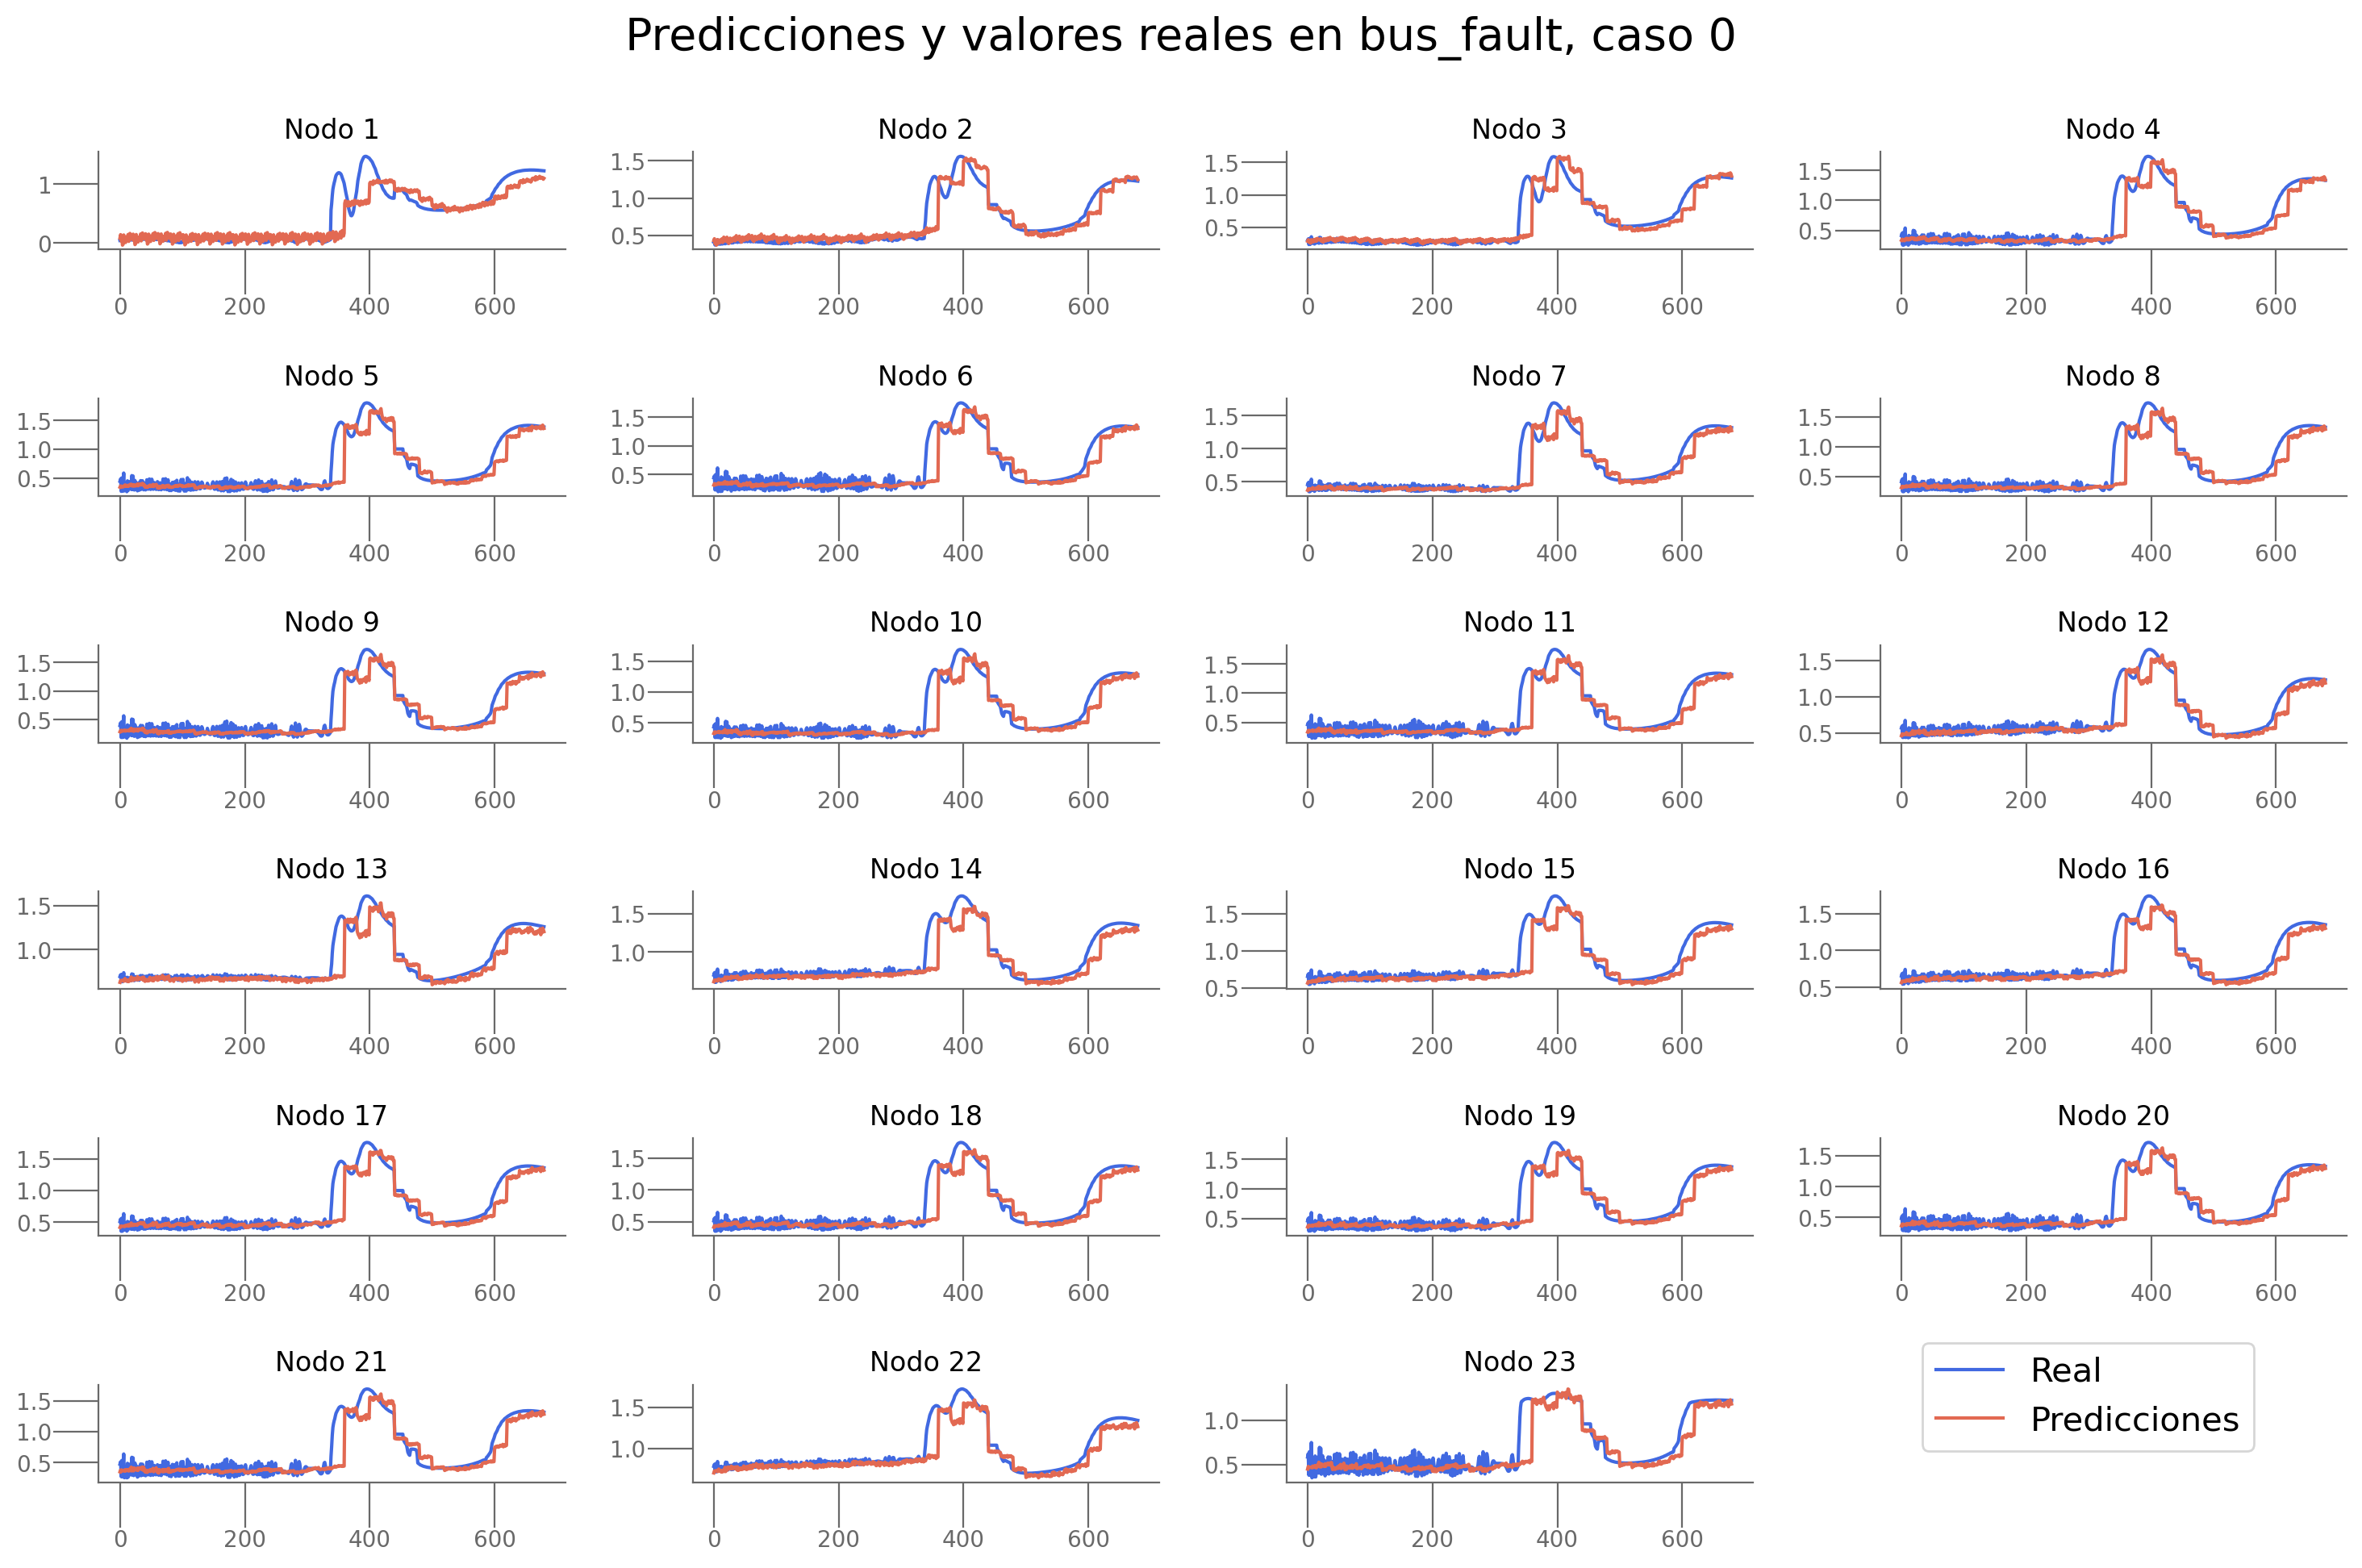


==================== GUARDANDO RESULTADOS ===================

         Modelo Params Fichero_resultados_experimento  Loss_tst    R2_tst  \
0          LSTM    NaN                            NaN  0.017298  0.603716   
1  LSTM_NOBATCH   None                           None  0.017459 -1.122112   

                                          Loss_nodes   R2_eval  Loss_eval  \
0  [0.0107881  0.01006583 0.01300934 0.01969145 0...  0.541346   0.024664   
1  [0.015273607, 0.010282311, 0.013488949, 0.0195... -2.717829   0.025920   

   Loss_final  
0    0.018978  
1    0.018612  

==================== RESULTADOS GUARDADOS ===================

Problem:  branch_fault
Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  92

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.2073 | Eval Loss: 0.1404 | Eval R2: -

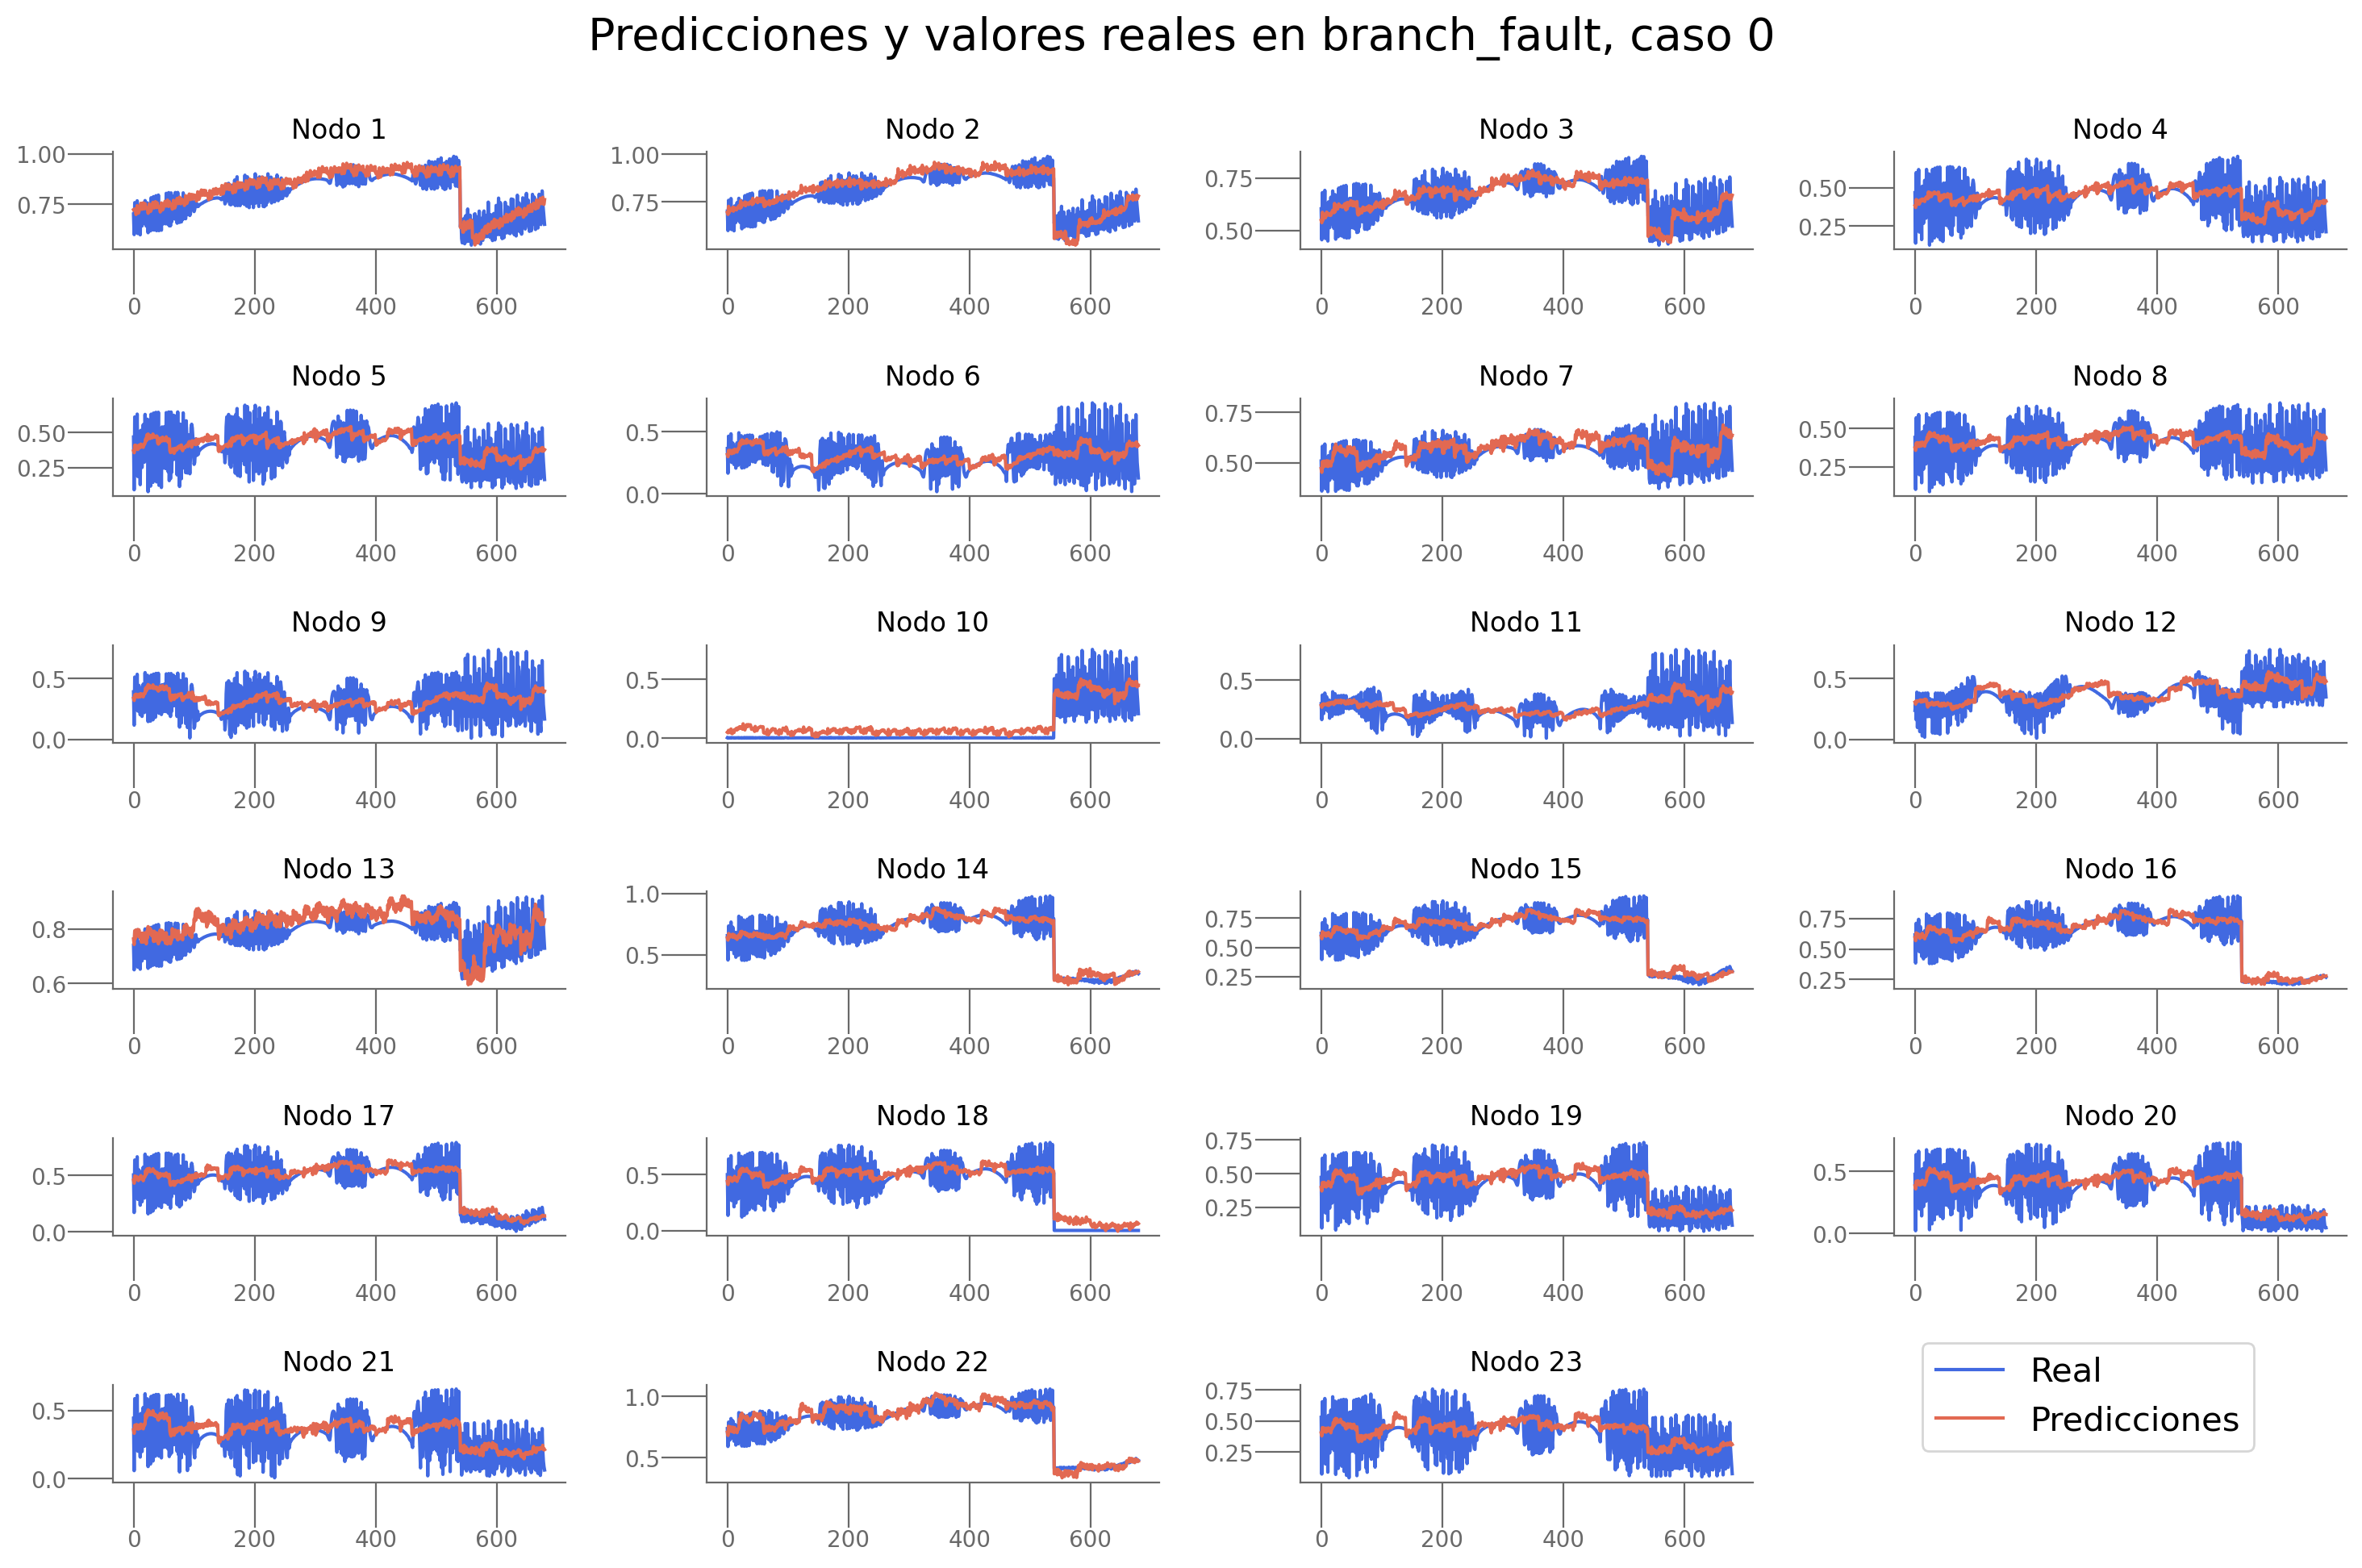


==================== GUARDANDO RESULTADOS ===================

         Modelo Params Fichero_resultados_experimento  Loss_tst    R2_tst  \
0          LSTM    NaN                            NaN  0.023216  0.608045   
1  LSTM_NOBATCH   None                           None  0.021628 -1.528487   

                                          Loss_nodes   R2_eval  Loss_eval  \
0  [0.01155095 0.00907443 0.01350776 0.02466182 0...  0.584785   0.029613   
1  [0.010803541, 0.0076828147, 0.011178697, 0.023... -2.690716   0.028298   

   Loss_final  
0    0.020435  
1    0.020590  

==================== RESULTADOS GUARDADOS ===================

Problem:  branch_trip
Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  101

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.3211 | Eval Loss: 0.0630 | Eval R2: -

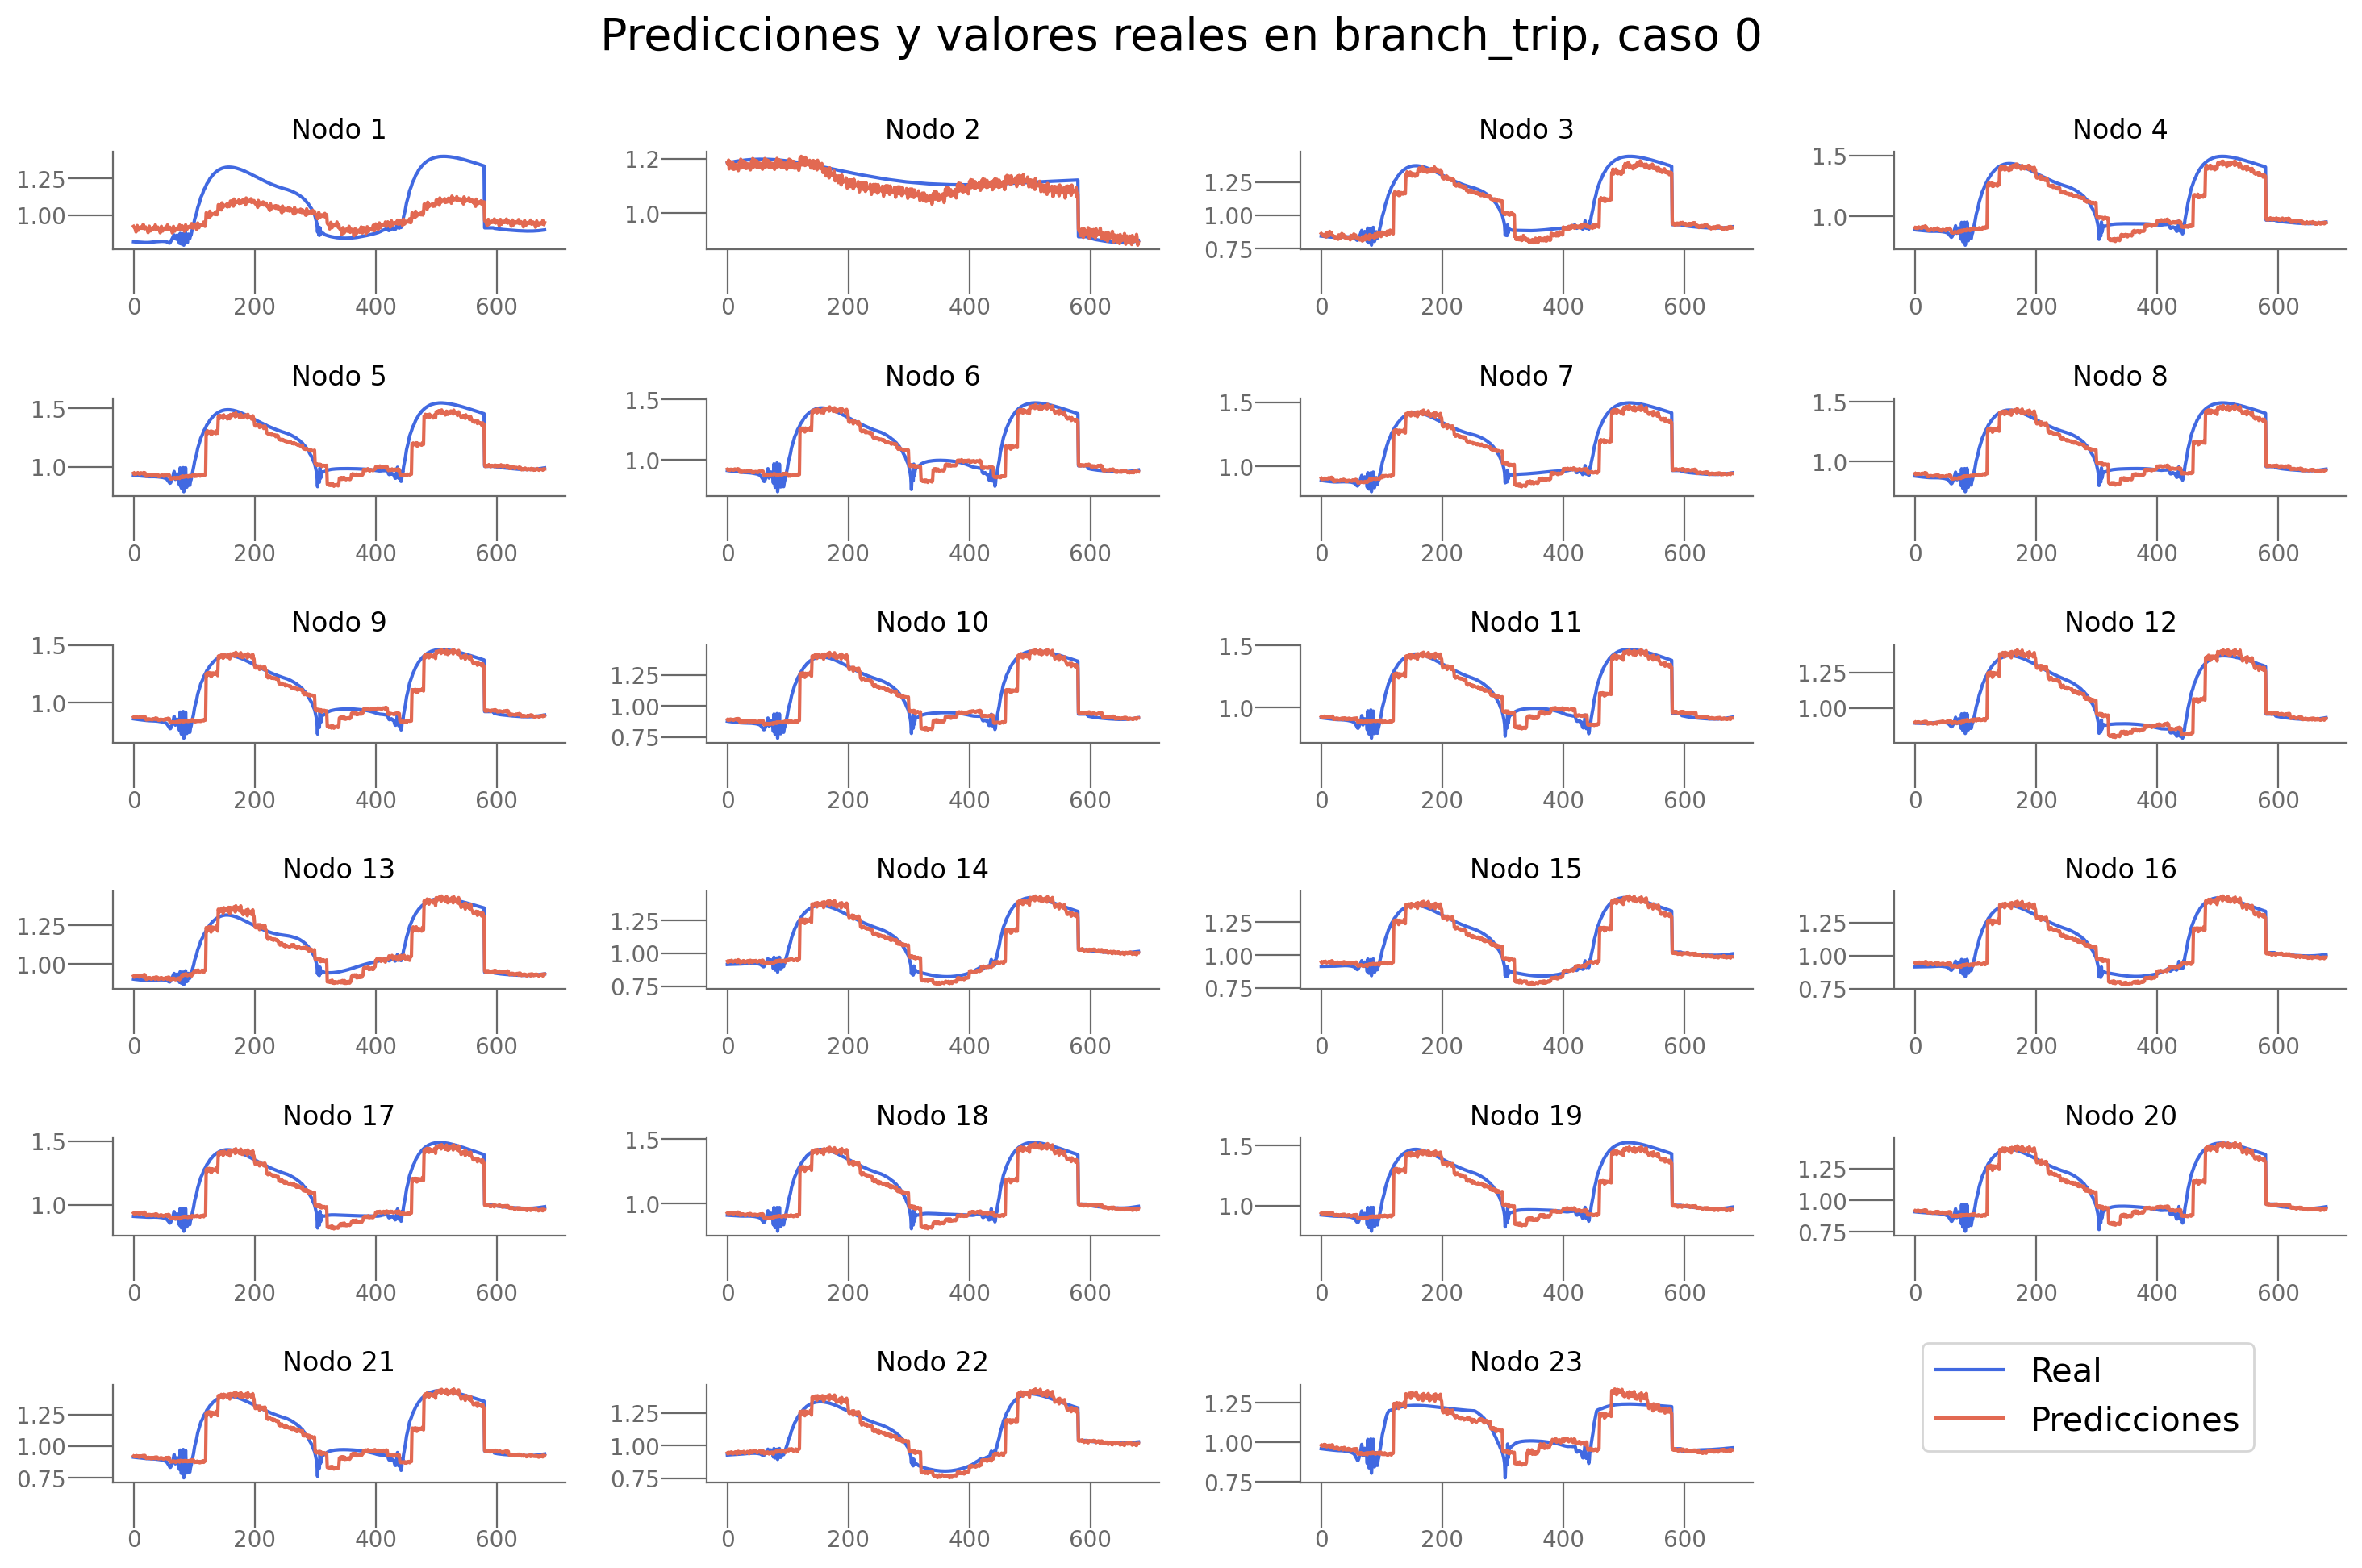


==================== GUARDANDO RESULTADOS ===================

         Modelo Params Fichero_resultados_experimento  Loss_tst    R2_tst  \
0          LSTM    NaN                            NaN  0.003700  0.398922   
1  LSTM_NOBATCH   None                           None  0.004787 -1.839737   

                                          Loss_nodes   R2_eval  Loss_eval  \
0  [0.0036937  0.00202668 0.00244704 0.00374463 0...  0.435549   0.003684   
1  [0.013897008, 0.0017746482, 0.003245119, 0.004... -1.577386   0.004085   

   Loss_final  
0    0.003296  
1    0.004827  

==================== RESULTADOS GUARDADOS ===================



In [8]:
problems = ["gen_trip", "bus_trip", "bus_fault", "branch_fault", "branch_trip"]
dataloader_params2 = {
    "batch_size": 5,
    "data_split_ratio": [0.7, 0.15, 0.15],
    "seed": 42,
    "keep_same": True,
    "use_batch": False
}
params_model = {
    "hidden_size": 50,
    "n_layers": 2
}

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

for problem in problems:
    print("Problem: ", problem)
    dataset_prob, situations_prob = loader.get_dataset(target=20, intro=100, step=20, one_ts_per_situation=False, start=1, type=problem)
    n_div_prob = loader.div
    n_nodes =dataset_prob.features[0].shape[0]
    n_target = dataset_prob.targets[0].shape[1]
    n_features = dataset_prob[0].x.shape[1]

    n_layers = params_model['n_layers']
    hidden_size = params_model['hidden_size']


    model_prob = LSTMModel(name="LSTM_NOBATCH", node_features=n_features, node_count=n_nodes, n_target=n_target, hidden_size=hidden_size, num_layers=n_layers)

    trainer_lstm = TrainerLSTMModel(model_prob, dataset_prob,device, f"./results/{problem}", dataloader_params2, batch=True)
    losses, eval_losses, r2scores = trainer_lstm.train(num_epochs=30, steps=50, num_early_stop=15)
    r2score_tst_prob, losses_tst_prob, loss_nodes_prob, predictions_prob, real_prob = trainer_lstm.test()
    

    plot_predictions(predictions_prob, real_prob, 20, 0, n_div_prob, problem)
    
    resultados_prob = {
        "loss_test": np.mean(losses_tst_prob),
        "r2_test": np.mean(r2score_tst_prob),
        "loss_nodes": np.mean(loss_nodes_prob, axis=0),
        "r2_eval_final": r2scores[-1],
        "loss_eval_final": eval_losses[-1],
        "loss_final": losses[-1]
    }

    trainer_lstm.save_model()
